In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from salishsea_tools import geo_tools, viz_tools, evaltools as et
import gsw
import netCDF4 as nc
import datetime as dt
import cmocean
import pickle
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
obslat=50.117
obslon=-125.223
saveloc='/ocean/eolson/MEOPAR/obs/IzettCTD/matchedHC1905.pkl'

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])
    e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
    print(mesh.variables.keys())

dict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


depth is 15 grid points at site or roughly 15.1 m


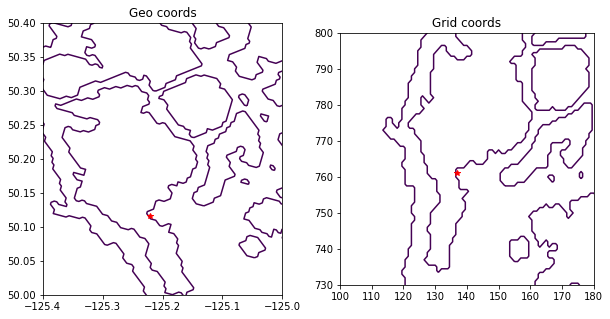

In [4]:
j,i=geo_tools.find_closest_model_point(obslon,obslat,navlon,navlat)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[0].plot(navlon[j,i],navlat[j,i],'r*')
ax[0].set_xlim(-125.4,-125)
ax[0].set_ylim(50,50.4)
viz_tools.set_aspect(ax[0],coords='map')
ax[0].set_title('Geo coords')
ax[1].contour(tmask[0,:,:],(.5,))
ax[1].plot(i,j,'r*')
ax[1].set_xlim(100,180)
ax[1].set_ylim(730,800)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('Grid coords')
ks=np.sum(tmask[:,j,i])
print('depth is {0} grid points at site or roughly {1:3.1f} m'.format(ks,np.sum(e3t_0[:ks,j,i])))

In [16]:
if os.path.isfile(saveloc):
    data=pickle.load(open( saveloc, 'rb' ) )
else:
    #load observations:
    df=pd.read_csv('/ocean/eolson/MEOPAR/obs/IzettCTD/Quadra_Hakai_BoL-data_201906-202004.txt',header=0,skiprows=(1,))
    df['dtUTC']=[dt.datetime(2014,1,1)+dt.timedelta(days=ii) for ii in df['Days']]
    df['SA']=[gsw.SA_from_SP(isp,1.4,obslon,obslat) for isp in df['TSG_S']]
    df['CT']=[gsw.CT_from_t(isa,ist,1.4) for isa,ist in zip(df['SA'],df['TSG_T'])]
    df['Z']=1.4
    df['Lat']=obslat
    df['Lon']=obslon
    df['k']=1
    df['i']=i
    df['j']=j
    # remove a day because it is currently missing from model output
    df.drop(df.loc[(df.dtUTC>=dt.datetime(2020,6,10))&(df.dtUTC<dt.datetime(2020,6,11))].index,inplace=True)
    # match obs to model output
    flen=1
    namfmt='nowcast'
    filemap={'vosaline':'grid_T','votemper':'grid_T'}
    fdict={'grid_T':1,}
    PATH='/results2/SalishSea/nowcast-green.201905/'
    runID='HC201905'
    dstart=dt.datetime(2014,12,19)
    dend=dt.datetime(2020,6,20)
    data=et.matchData(df,filemap,fdict,dstart,dend,namfmt,PATH,flen,preIndexed=True)
    with open(saveloc,'wb') as f:
        pickle.dump(data,f)

## Temperature and Salinity Comparisons

Text(0, 0.5, 'Model Cons. Temp. (deg C)')

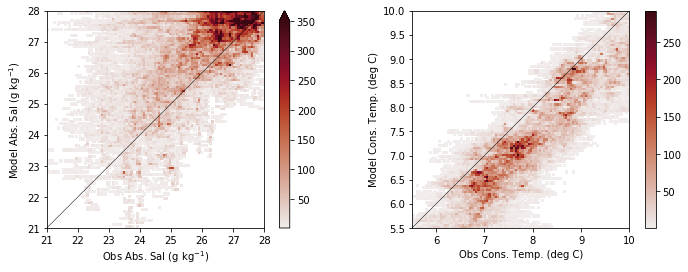

In [17]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
_,_,_,m0=ax[0].hist2d(data['SA'],data['mod_vosaline'],bins=np.linspace(21,28,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=800,vmin=1,vmax=350)
fig.colorbar(m0,ax=ax[0],extend='max')
ax[0].set_aspect(1)
ax[0].set_xlim(21,28)
ax[0].set_ylim(21,28)
ax[0].plot((21,28),(21,28),'k-',lw=.5);
ax[0].set_xlabel('Obs Abs. Sal (g kg$^{-1}$)')
ax[0].set_ylabel('Model Abs. Sal (g kg$^{-1}$)')
_,_,_,m1=ax[1].hist2d(data['CT'],data['mod_votemper'],bins=np.linspace(5.5,10,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=350)
fig.colorbar(m1,ax=ax[1])
ax[1].set_aspect(1)
ax[1].set_xlim(5.5,10)
ax[1].set_ylim(5.5,10)
ax[1].plot((5.5,10),(5.5,10),'k-',lw=.5)
ax[1].set_xlabel('Obs Cons. Temp. (deg C)')
ax[1].set_ylabel('Model Cons. Temp. (deg C)')

### Stats
N: number of data points included in calculation (although they are not statistica
bias: mean of model - obs
RMSE: root mean square error
Willmott Skill Score is between 0 and 1, with 1 representing a perfect match between model and observations

In [18]:
s_sa=et.stats(data['SA'],data['mod_vosaline'])
print('Absolute Salinity\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_sa))

Absolute Salinity
 N: 447830
 bias: 0.8393380791708118
 RMSE: 1.4592866685270445
 Willmott Skill Score: 0.7603133483217335


In [19]:
s_ct=et.stats(data['CT'],data['mod_votemper'])
print('Conservative Temperature\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_ct))

Conservative Temperature
 N: 447830
 bias: -0.8051871415688563
 RMSE: 1.2563920299941473
 Willmott Skill Score: 0.9780175111340039


#### Full time series

Text(0, 0.5, 'Abs. Sal.\n (g kg$^{-1}$)')

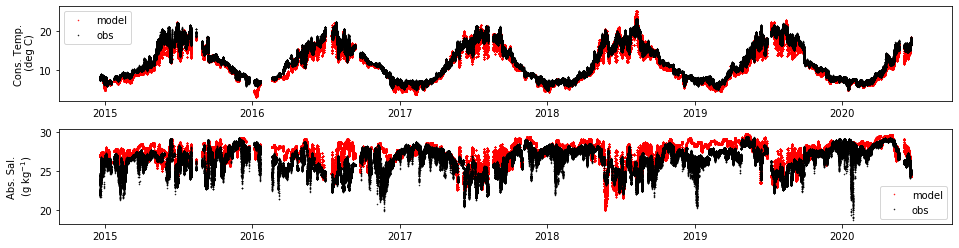

In [20]:
fig,ax=plt.subplots(2,1,figsize=(16,4))
fig.subplots_adjust(hspace=.3)
ax[0].plot(data['dtUTC'],data['mod_votemper'],'r.',label='model',ms=1)
ax[0].plot(data['dtUTC'],data['CT'],'k.',label='obs',ms=1)
ax[0].legend()
ax[0].set_ylabel('Cons. Temp.\n (deg C)')
ax[1].plot(data['dtUTC'],data['mod_vosaline'],'r.',label='model',ms=1)
ax[1].plot(data['dtUTC'],data['SA'],'k.',label='obs',ms=1)
ax[1].legend()
ax[1].set_ylabel('Abs. Sal.\n (g kg$^{-1}$)')

#### By year

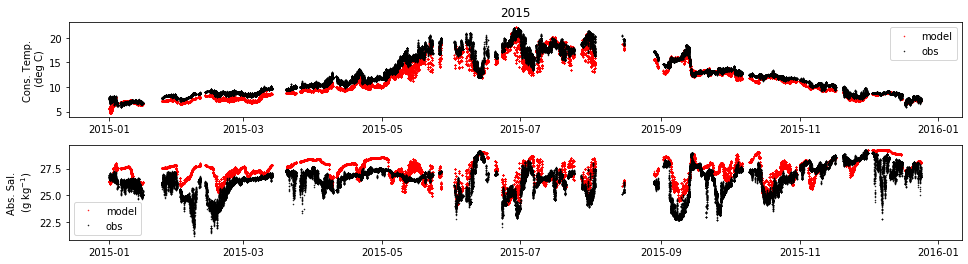

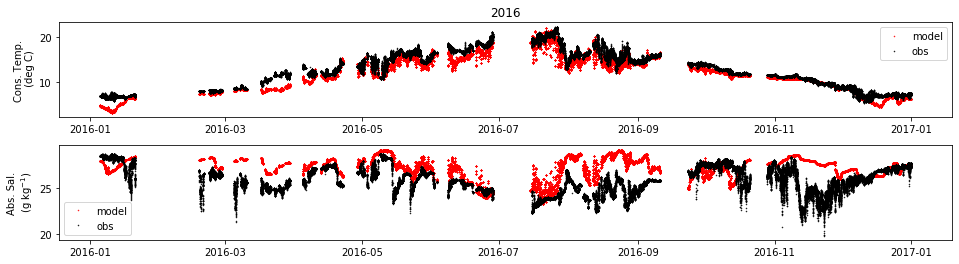

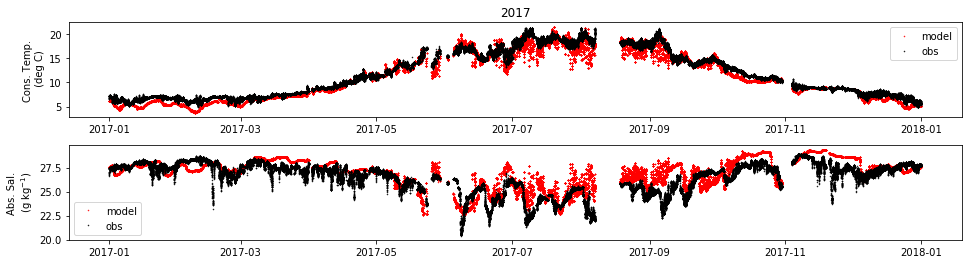

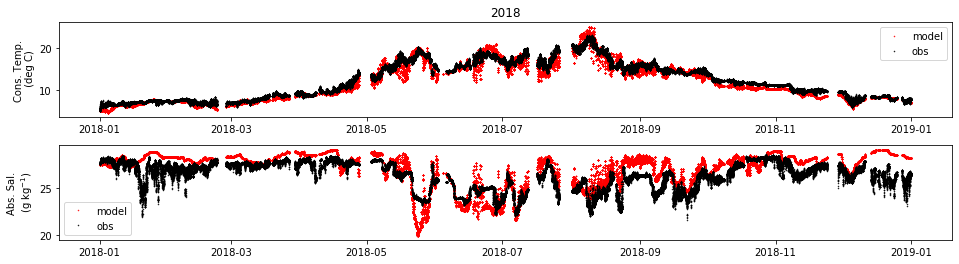

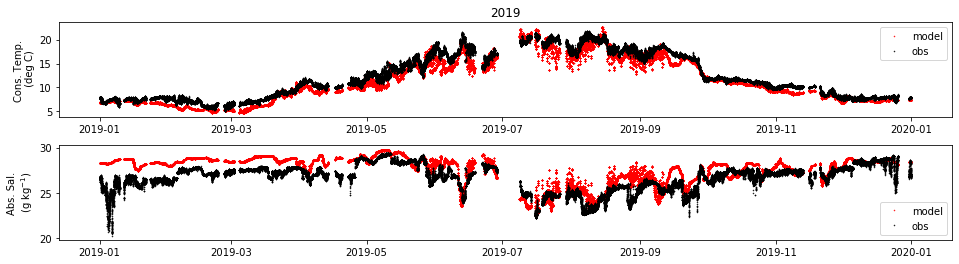

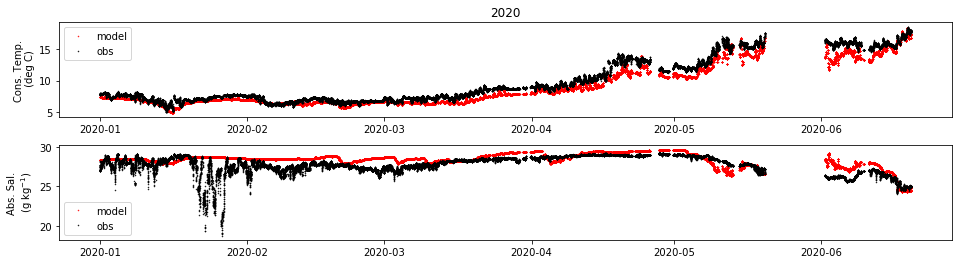

In [21]:
for iyear in range(2015,2021):
    fig,ax=plt.subplots(2,1,figsize=(16,4))
    fig.subplots_adjust(hspace=.3)
    iii=[ii.year==iyear for ii in data['dtUTC']]
    idata=data.loc[iii]
    ax[0].plot(idata['dtUTC'],idata['mod_votemper'],'r.',label='model',ms=1)
    ax[0].plot(idata['dtUTC'],idata['CT'],'k.',label='obs',ms=1)
    ax[0].legend()
    ax[0].set_ylabel('Cons. Temp.\n (deg C)')
    ax[0].set_title(str(iyear))
    ax[1].plot(idata['dtUTC'],idata['mod_vosaline'],'r.',label='model',ms=1)
    ax[1].plot(idata['dtUTC'],idata['SA'],'k.',label='obs',ms=1)
    ax[1].legend()
    ax[1].set_ylabel('Abs. Sal.\n (g kg$^{-1}$)')

## SSH

### Tides: compare model SSH to tidal predictions at  Whaletown, B.C. Station Number: 8038  (50.108,-125.052)

- Heriot bay predictions are not archived according to http://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/maps-cartes/inventory-inventaire-eng.asp?user=isdm-gdsi&region=MEDS&tst=1&perm=0

In [22]:
dfssh=pd.read_csv('/ocean/eolson/MEOPAR/obs/IzettCTD/WhaletownTidePred/8038-01-JAN-2015_slev.csv',
                  skiprows=7,delimiter=',',index_col=None,usecols=[0,1])

In [23]:
dfssh

,Obs_date,SLEV(metres)
0,2017/06/16 22:00,2.46
1,2017/06/16 23:00,2.19
2,2017/06/17 00:00,2.11
3,2017/06/17 01:00,2.23
4,2017/06/17 02:00,2.61
...,...,...
13652,2019/06/13 20:00,2.79
13653,2019/06/13 21:00,3.42
13654,2019/06/13 22:00,3.91
13655,2019/06/13 23:00,4.15


In [24]:
dfssh['dtUTC']=[dt.datetime.strptime(ii, '%Y/%m/%d %H:%M') for ii in dfssh['Obs_date']]

In [25]:
dfssh

,Obs_date,SLEV(metres),dtUTC
0,2017/06/16 22:00,2.46,2017-06-16 22:00:00
1,2017/06/16 23:00,2.19,2017-06-16 23:00:00
2,2017/06/17 00:00,2.11,2017-06-17 00:00:00
3,2017/06/17 01:00,2.23,2017-06-17 01:00:00
4,2017/06/17 02:00,2.61,2017-06-17 02:00:00
...,...,...,...
13652,2019/06/13 20:00,2.79,2019-06-13 20:00:00
13653,2019/06/13 21:00,3.42,2019-06-13 21:00:00
13654,2019/06/13 22:00,3.91,2019-06-13 22:00:00
13655,2019/06/13 23:00,4.15,2019-06-13 23:00:00


In [26]:
jssh,issh=geo_tools.find_closest_model_point(-125.052,50.108,navlon,navlat)
# point is on land so move by 1 
issh=issh-1
dfssh['i']=issh
dfssh['j']=jssh

In [27]:
flen=1
namfmt='nowcast'
filemap={'sossheig':'grid_T',}
fdict={'grid_T':1,}
PATH='/results2/SalishSea/nowcast-green.201905/'
runID='HC201905'
dstart=dt.datetime(2017,6,1)
dend=dt.datetime(2019,6,15)

In [28]:
dataSSH=et.matchData(dfssh,filemap,fdict,dstart,dend,namfmt,PATH,flen,preIndexed=True,sdim=2)

progress: 0.0%
progress: 36.61126162407557%
progress: 73.22252324815113%


Text(0, 0.5, 'SSH (m)')

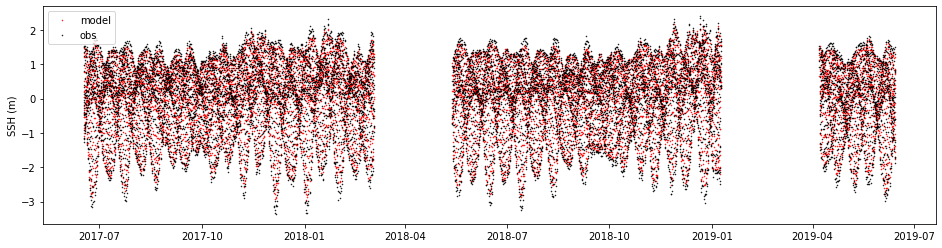

In [29]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC']+dt.timedelta(hours=.5),dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r.',label='model',ms=1)
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k.',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')

(736511.0, 736540.0)

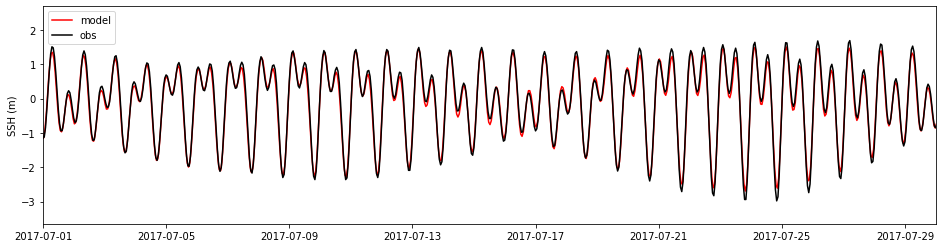

In [30]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC']+dt.timedelta(hours=.5),dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r-',label='model',ms=1)
# model is actually value on half hour but was matched to obs on the hour, so added 30 min to model times
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2017,7,1),dt.datetime(2017,7,30)))

(736938.0, 736967.0)

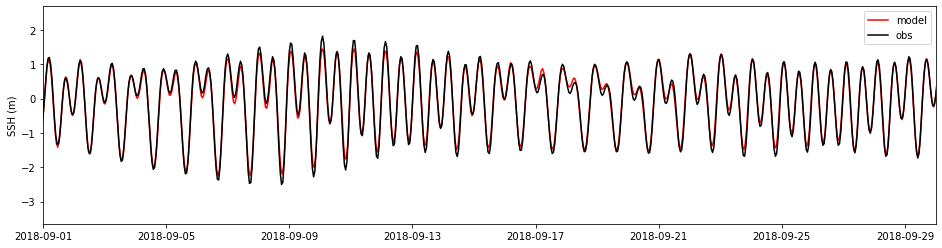

In [31]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC']+dt.timedelta(hours=.5),dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r-',label='model',ms=1)
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2018,9,1),dt.datetime(2018,9,30)))

#### Campbell River #8074 Observed
downloaded from http://odylab.ocean.dal.ca/vtg/index.php?poi=8074
(GC website not responding)

In [34]:
dfsshC=pd.read_csv('/ocean/eolson/MEOPAR/obs/tides/data_8074_dl.csv',
                  skiprows=1,delimiter=',',index_col=None,usecols=[0,1])

In [37]:
dfsshC.head(3)

,Time,Observed
0,2019/09/04 10:00,1.667
1,2019/09/04 11:00,1.639
2,2019/09/04 12:00,1.522


In [42]:
jsshC,isshC=geo_tools.find_closest_model_point(-125.247,50.042,navlon,navlat)
dfsshC['i']=isshC
dfsshC['j']=jsshC

In [43]:
dfsshC['dtUTC']=[dt.datetime.strptime(ii, '%Y/%m/%d %H:%M') for ii in dfsshC['Time']]

In [44]:
dstartC=dt.datetime(2019,9,4)
dendC=dt.datetime(2020,9,1)
dataSSHC=et.matchData(dfsshC,filemap,fdict,dstartC,dendC,namfmt,PATH,flen,preIndexed=True,sdim=2)

progress: 0.0%
progress: 57.45805561939784%


Text(0, 0.5, 'SSH (m)')

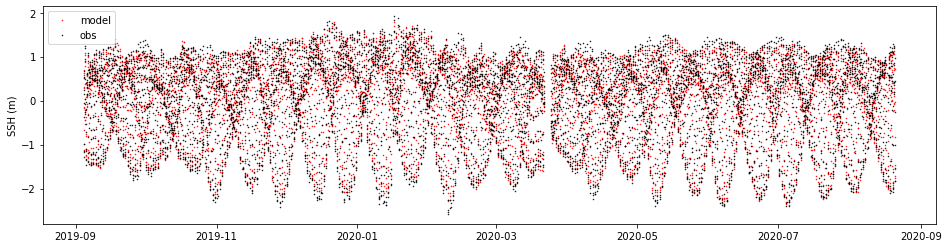

In [55]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ii=~pd.isnull(dataSSHC['Observed'])
ax.plot(dataSSHC['dtUTC'][ii]+dt.timedelta(hours=.5),dataSSHC['mod_sossheig'][ii]-np.mean(dataSSHC['mod_sossheig'][ii]),'r.',label='model',ms=1)
ax.plot(dataSSHC['dtUTC'][ii],dataSSHC['Observed'][ii]-np.mean(dataSSHC['Observed'][ii]),'k.',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')

(737307.0, 737333.0)

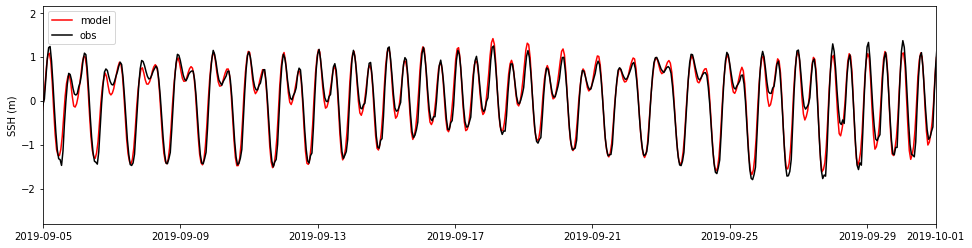

In [51]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSHC['dtUTC']+dt.timedelta(hours=.5),dataSSHC['mod_sossheig']-np.mean(dataSSHC['mod_sossheig']),'r-',label='model',ms=1)
ax.plot(dataSSHC['dtUTC'],dataSSHC['Observed']-np.mean(dataSSHC['Observed']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2019,9,5),dt.datetime(2019,10,1)))

(737394.0, 737424.0)

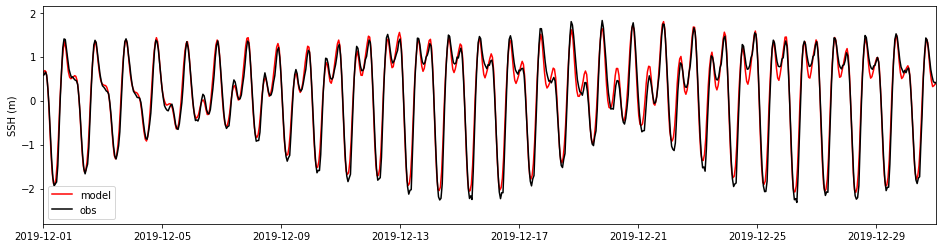

In [53]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSHC['dtUTC']+dt.timedelta(hours=.5),dataSSHC['mod_sossheig']-np.mean(dataSSHC['mod_sossheig']),'r-',label='model',ms=1)
ax.plot(dataSSHC['dtUTC'],dataSSHC['Observed']-np.mean(dataSSHC['Observed']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2019,12,1),dt.datetime(2019,12,31)))

(737456.0, 737483.0)

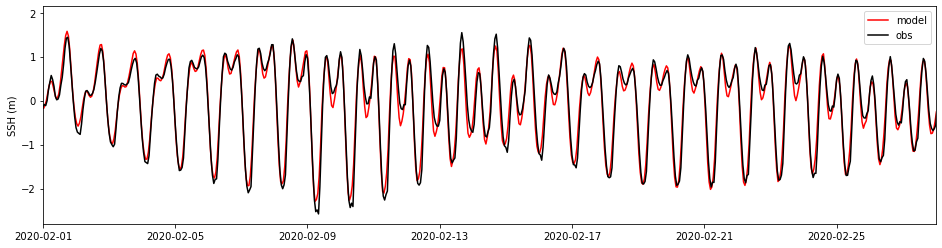

In [52]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSHC['dtUTC']+dt.timedelta(hours=.5),dataSSHC['mod_sossheig']-np.mean(dataSSHC['mod_sossheig']),'r-',label='model',ms=1)
ax.plot(dataSSHC['dtUTC'],dataSSHC['Observed']-np.mean(dataSSHC['Observed']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2020,2,1),dt.datetime(2020,2,28)))